# Import

In [1]:
import pickle
from skimage import io
import torch
import tqdm
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
import torchvision
from torchvision import datasets, models, transforms as T
import os
import numpy as np
from IPython.display import clear_output, FileLink

In [1]:

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    DEVICE = torch.device("cpu")
    print('CUDA is not available.  Training on CPU ...')
else:
    DEVICE = torch.device("cuda")
    print('CUDA is available!  Training on GPU ...')

print(DEVICE)

CUDA is not available.  Training on CPU ...
cpu


In [2]:
!pip install natsort
from natsort import natsorted

# Dataset

In [37]:
class CarColorDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        # режим работы
        self.mode = mode
        self.len_ = len(self.files)    
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)                 
    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x, dtype='uint8')
        
        if self.mode == 'train':
            x = self.transform_train(x)
        if self.mode == 'val':
            x = self.transform_test(x)
        if self.mode == 'test':
            x = self.transform_test(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def transform_train(self, image):
        transform = T.Compose([
            T.ToPILImage(),
            T.RandomEqualize(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ])
        return transform(image)
        
    def transform_val(self, image):
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        return transform(image)

    def transform_test(self, image):
        transform = T.Compose([
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        return transform(image)

In [8]:
def imshow(inp, title=None, plt_ax=plt):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [16]:
# укажите путь к трейну и тесту, для приват теста в самом низу смотреть (раздел Private Test)
TRAIN_DIR = Path('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/train')
TEST_DIR = Path('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_img = natsorted(list(map(str, TEST_DIR.rglob('*.jpg')))) # sort by number
test_files = list(map(Path, test_img))

In [11]:
test_files[:5] # смотрим правильно ли отсортировались файлы теста (0,1,2,3,4, ...)

[PosixPath('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test/0.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test/1.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test/2.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test/3.jpg'),
 PosixPath('/kaggle/input/car-dataset/car_color_dataset/car_color_dataset/public_test/4.jpg')]

In [12]:
from sklearn.model_selection import train_test_split
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [38]:
val_dataset = CarColorDataset(val_files, mode='val')
train_dataset = CarColorDataset(train_files, mode='train')
test_dataset = CarColorDataset(test_files, mode="test")

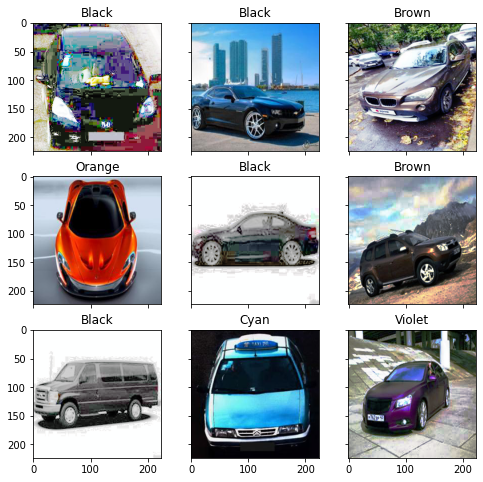

In [39]:
# let's look at images in train
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(), \
          title=img_label,plt_ax=fig_x)

# Model

In [24]:
model = models.resnet101(pretrained=True)

In [25]:
# resnet
# количество классов для предсказания
n_classes = len(np.unique(train_val_labels))

# замораживам все веса модели
for param in model.parameters():
    param.requires_grad = False

# размораживаем последние 2 слоя модели
# (количество слоев / параметров для разморозки получено эксперементально)
for par in model.layer3.parameters():
    par.requires_grad=True
for p in model.layer4.parameters():
    p.requires_grad=True

model.avgpool=nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Linear(in_features=2048, out_features=n_classes, bias=True)

model = model.to(DEVICE)

In [15]:
model # look at the model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 


# Train + validation

In [16]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
from sklearn.metrics import f1_score
def score(y_true, y_pred):
    return f1_score(y_true.cpu().numpy(), y_pred.cpu().numpy(), average='macro')

In [18]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler=None):

    model.train()

    running_loss = 0.0
    running_score = 0
    processed_data = 0

    for inputs, labels in train_loader:

        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()

        running_loss += loss.item() * inputs.size(0)
        running_score += score(labels.data, preds)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_score = running_score / len(train_loader)

    return train_loss, train_score

In [19]:
def eval_epoch(model, val_loader, criterion):

    model.eval()

    running_loss = 0.0
    running_score = 0
    processed_size = 0

    for inputs, labels in val_loader:
        
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)
            
        running_loss += loss.item() * inputs.size(0)
        running_score += score(labels.data, preds)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_score = running_score / len(val_loader)

    return val_loss, val_score

In [26]:
criterion = nn.CrossEntropyLoss()

# lr, step_size и gamma могут иметь другие значения, они подбирются и меняются по ходу обучения
optimizer = optim.Adam(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2)

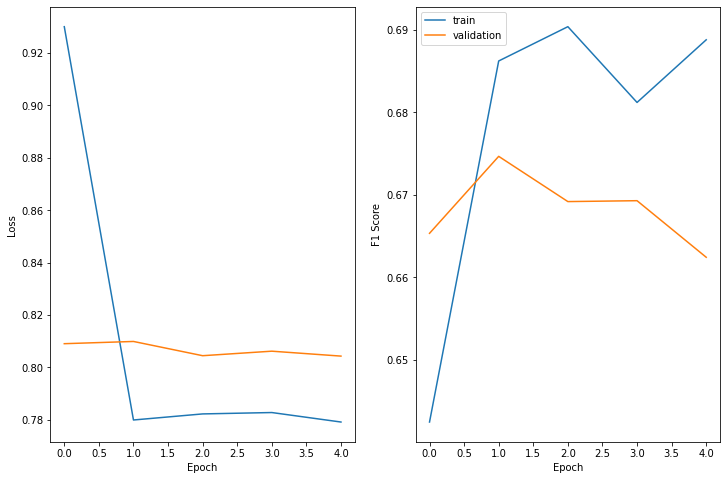

epoch 5
val_score: 0.6624276950028598
val_loss: 0.8043111374074854



In [27]:
# фиксируем модели с хорошим скор или низким loss
min_val_loss = np.inf
max_val_score = -1

# для построения графиков
history = []

EPOCHS = 5

for epoch in range(EPOCHS):

    train_loss, train_score = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_loss, val_score = eval_epoch(model, val_loader, criterion)
    
    history.append((train_loss, train_score, val_loss, val_score))
    
    # histories
    train_loss_hist, train_score_hist, val_loss_hist, val_score_hist = zip(*history)
    
    clear_output(True)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    
    ax[0].plot(train_loss_hist, label='train loss')
    ax[0].plot(val_loss_hist, label='validation loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    plt.legend()

    ax[1].plot(train_score_hist, label='train')
    ax[1].plot(val_score_hist, label='validation')
    ax[1].set_ylabel('F1 Score')
    ax[1].set_xlabel('Epoch')

    plt.legend()
    plt.show()
    
    # for exact values
    print("epoch", epoch + 1)
    print("val_score:", val_score)
    print("val_loss:", val_loss, end='\n\n')
    
    # best model in eval loss
    if val_loss_hist[-1] < min_val_loss:
        min_val_loss = val_loss_hist[-1]
        torch.save(model.state_dict(), 'best_val_model.pt')
        
    # best model in eval score
    if val_score_hist[-1] > max_val_score:
        max_val_score = val_score_hist[-1]
        torch.save(model.state_dict(), 'best_score_model.pt')

In [28]:
# нужно указать путь к модели (имя как в примере)
model.load_state_dict(torch.load('/kaggle/input/final-model/09856_resnet101.pt'))

<All keys matched successfully>

In [29]:
# выбираем лучшую модель по результатам валидации из нескольких сохраненных
# использовались разные модели и разные подходы к обучению
val_loss, val_score = eval_epoch(model, val_loader, criterion)
print("val_score:", val_score)
print("val_loss:", val_loss)

val_score: 0.986067245413338
val_loss: 0.049778641778368556


In [ ]:
# save best model weigts;   val score >  0.996653652; val_loss < 0.015214583
torch.save(model.state_dict(), 'best_model.pt')

In [30]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in tqdm.tqdm(test_loader):
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)           
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [31]:
result = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(result, axis=1))
with open("submit_res101.csv", 'w') as f_res:
    for row in preds:
        f_res.write(row + '\n')
        
display(FileLink("submit_res101.csv"))

100%|██████████| 23/23 [00:13<00:00,  1.74it/s]


/kaggle/working/submit_res101.csv

# Private test

In [32]:
TEST_DIR = Path('/kaggle/input/car-dataset/private_dataset/private_dataset')
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_img = natsorted(list(map(str, TEST_DIR.rglob('*.jpg')))) # sort by number
test_files = list(map(Path, test_img))

print(len(test_files))
test_files[:15] # check sort

1434


[PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/0.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/1.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/2.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/3.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/4.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/5.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/6.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/7.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/8.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/9.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/10.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_dataset/private_dataset/11.jpg'),
 PosixPath('/kaggle/input/car-dataset/private_data

In [33]:
test_dataset = CarColorDataset(test_files, mode="test")

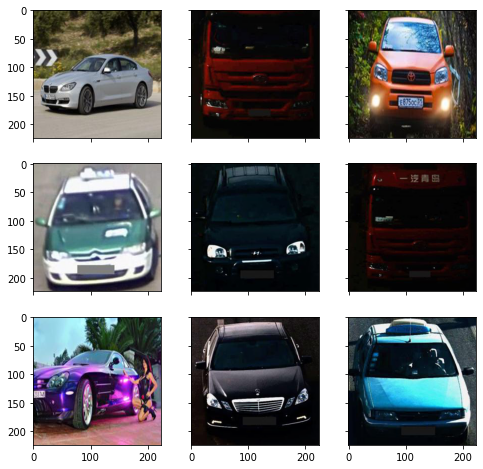

In [34]:
# let's look at private images
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,500))
    im_test = test_dataset[random_characters]
    
    imshow(im_test.data.cpu(), plt_ax=fig_x)

In [35]:
BATCH_SIZE = 64

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [36]:
# нужно указать путь к модели (имя как в примере)
model.load_state_dict(torch.load('/kaggle/input/final-model/09856_resnet101.pt'))

<All keys matched successfully>

In [38]:
result = predict(model, test_loader)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(result, axis=1))

assert len(preds) == len(test_files)

with open("submit_final.csv", 'w') as f_res:
    for row in preds:
        f_res.write(row + '\n')
        

print("done-danone :-P \ncheck  submit")
display(FileLink("submit_final.csv"))

100%|██████████| 23/23 [00:10<00:00,  2.25it/s]

done-danone :-P 
check  submit


/kaggle/working/submit_final.csv